In [3]:
###########################################################
# combined_poisson_geostat_example.py
# ---------------------------------------------------------
# Demonstrates:
# (1) Generating a "true" Poisson geostat dataset on a 10x10 grid
# (2) Training a neural net (similar to '06' style) to invert
#     partial observations -> GP parameters
# (3) Inferring the "true" data parameters, and plotting
#     predicted vs. true y for all grid points.
###########################################################

import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [4]:
###########################################################
# 0. HELPER FUNCTIONS FOR DISTANCES & KERNELS (JAX)
###########################################################
def distance_matrix_jax(x1, x2):
    """
    x1: [N, D]
    x2: [M, D]
    returns: [N, M] with Euclidean distances
    """
    diff = x1[:, None, :] - x2[None, :, :]
    return jnp.sqrt(jnp.sum(diff**2, axis=-1))

def exponential_covariance_jax(x1, x2, lengthscale=1.0, variance=1.0):
    """
    Exponential covariance: variance * exp(-dist / lengthscale).
    """
    dists = distance_matrix_jax(x1, x2)
    return variance * jnp.exp(-dists / lengthscale)

###########################################################
# 1. TRUE DATA GENERATION
###########################################################
rng_key = random.PRNGKey(0)

# We'll define a 10x10 grid of points (0..10 in each dimension)
grid_size = 10
x = np.stack(np.meshgrid(np.linspace(0, 10, grid_size),
                         np.linspace(0, 10, grid_size)), axis=-1).reshape(-1, 2)
n = x.shape[0]  # 100 total points

# True parameters
lengthscale_true = 2.0
variance_true    = 2.0

# Covariance for the latent field
# (Here we show a NumPy approach; you can also do a JAX version.)

cov_matrix_np = variance_true * np.exp(-cdist(x, x) / lengthscale_true)

# Sample the latent field
y_latent = np.random.multivariate_normal(mean=np.zeros(n), cov=cov_matrix_np)

# Poisson outcomes
y = np.random.poisson(lam=np.exp(y_latent))

# Introduce missing values (30% missing)
obs_fraction = 0.7
obs_idx = np.random.choice(n, size=int(obs_fraction * n), replace=False)
miss_idx = np.setdiff1d(np.arange(n), obs_idx)

x_obs = x[obs_idx]  # Coordinates of observed points
y_obs = y[obs_idx]  # Observed counts

print("True data generated!")
print(f"  lengthscale_true = {lengthscale_true}, variance_true = {variance_true}")
print(f"  Observed points: {len(obs_idx)}, Missing points: {len(miss_idx)}")

True data generated!
  lengthscale_true = 2.0, variance_true = 2.0
  Observed points: 70, Missing points: 30


In [5]:
###########################################################
# 2. PRIOR & SIMULATOR FOR SYNTHETIC DATA
###########################################################
def sample_prior(rng_key, batch_size=1):
    """
    Draws samples of parameters from prior.
    We assume lengthscale, variance ~ LogNormal(0, 1) as an example.
    """
    rng_split = random.split(rng_key, batch_size + 1)
    params_list = []
    for i in range(batch_size):
        # lengthscale
        ls = jnp.exp(dist.Normal(0.0, 1.0).sample(rng_split[i]))
        # variance
        var = jnp.exp(dist.Normal(0.0, 1.0).sample(rng_split[i]))
        params_list.append(jnp.array([ls, var]))
    return jnp.stack(params_list, axis=0)

def simulate_poisson_geostat(params, rng_key):
    """
    For each param set [lengthscale, variance], create a latent GP on the entire grid x,
    then sample Poisson counts from exp(latent).
    
    Returns: counts shape [batch_size, n], where n=100 (the full grid).
    """
    batch_size = params.shape[0]
    subkeys = random.split(rng_key, batch_size + 1)
    
    data_out = []
    for i in range(batch_size):
        ls_i  = params[i, 0]
        var_i = params[i, 1]
        cov = exponential_covariance_jax(x, x, lengthscale=ls_i, variance=var_i)
        latent = dist.MultivariateNormal(loc=jnp.zeros(n),
                                         covariance_matrix=cov).sample(subkeys[i])
        counts = dist.Poisson(jnp.exp(latent)).sample(subkeys[i])
        data_out.append(counts)
    return jnp.stack(data_out, axis=0)  # [batch_size, n]

def mask_data(full_data, obs_fraction=0.7, rng_key=None):
    """
    Randomly masks out (1 - obs_fraction) of the entries by placing -1.
    This simulates partial observations. We do it row by row.
    """
    batch_size, n_points = full_data.shape
    if rng_key is None:
        rng_key = random.PRNGKey(999)
    subkeys = random.split(rng_key, batch_size + 1)
    
    out_data = []
    for i in range(batch_size):
        counts_i = full_data[i]
        # We'll "observe" ~ obs_fraction
        n_obs = int(obs_fraction * n_points)
        # choose which indices to observe
        idx = dist.Categorical(logits=jnp.ones(n_points)).sample(subkeys[i], sample_shape=(n_obs,))
        # This approach isn't guaranteed unique indices, so let's do an alternative
        # We'll do it more simply with random.permutation:
        perm = random.permutation(subkeys[i], jnp.arange(n_points))
        obs_idx_batch = perm[:n_obs]
        mask_array = -jnp.ones_like(counts_i)  # fill with -1
        mask_array = mask_array.at[obs_idx_batch].set(counts_i[obs_idx_batch])
        out_data.append(mask_array)
    return jnp.stack(out_data, axis=0)

###########################################################
# 3. NEURAL NETWORK FOR PARAMETER INFERENCE
###########################################################
class SimpleParamNet(nn.Module):
    """
    MLP that takes in the 'masked' data (size n=100) as input
    and outputs the 2 parameters [lengthscale, variance].
    Realistically, you might want a more sophisticated approach
    which also includes the (x,y) positions, etc.
    """
    def __init__(self, input_dim=100, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        out = self.fc3(h)  # shape: (batch_size, 2)
        return out

###########################################################
# 4. TRAINING LOOP (SYNTHETIC, ONLINE)
###########################################################
def train_model(n_epochs=10000, batch_size=32, lr=1e-3, obs_fraction=0.7):
    rng = random.PRNGKey(42)
    
    model = SimpleParamNet(input_dim=n, hidden_dim=128)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss_fn = nn.MSELoss()

    loss_list = []

    for epoch in range(n_epochs):
        # 1) Sample parameters
        rng, subkey = random.split(rng)
        params_batch = sample_prior(subkey, batch_size=batch_size)  # shape [batch_size, 2]

        # 2) Simulate Poisson geostat data
        rng, subkey = random.split(rng)
        full_data = simulate_poisson_geostat(params_batch, subkey)  # shape [batch_size, n]

        # 3) Mask out some fraction
        rng, subkey = random.split(rng)
        masked_data = mask_data(full_data, obs_fraction=obs_fraction, rng_key=subkey)  # shape [batch_size, n]

        # 4) Convert JAX -> torch
        masked_data_torch = torch.tensor(np.array(masked_data), dtype=torch.float32)
        params_true_torch = torch.tensor(np.array(params_batch), dtype=torch.float32)

        # 5) Forward pass
        pred_params = model(masked_data_torch)

        # 6) MSE loss in parameter space (very naive)
        loss = mse_loss_fn(pred_params, params_true_torch)
        loss_list.append(loss.item())

        # 7) Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}")

    plt.plot(loss_list)
    return model

###########################################################
# 5. FUNCTION TO PREDICT COUNTS (GIVEN PARAM ESTIMATE)
###########################################################
def predict_counts(params, rng_key=None):
    """
    Given a set of parameters [lengthscale, variance] for the entire 100-point grid,
    sample new latent + Poisson outcome from the same kernel. 
    For a deterministic "mean" prediction, one might do E[y] ~ E[ exp(latent) ], 
    but we will do a single sample for demonstration.
    """
    if rng_key is None:
        rng_key = random.PRNGKey(9999)
    ls, var = params
    cov = exponential_covariance_jax(x, x, lengthscale=ls, variance=var)
    latent = dist.MultivariateNormal(loc=jnp.zeros(n), covariance_matrix=cov).sample(rng_key)
    counts = dist.Poisson(jnp.exp(latent)).sample(rng_key)
    return np.array(counts)


Epoch [500/4500], Loss: 2.149496
Epoch [1000/4500], Loss: 6.318810
Epoch [1500/4500], Loss: 5479.275391
Epoch [2000/4500], Loss: 30.229330
Epoch [2500/4500], Loss: 4.513269
Epoch [3000/4500], Loss: 5.642974
Epoch [3500/4500], Loss: 5.029656
Epoch [4000/4500], Loss: 93.181686
Epoch [4500/4500], Loss: 1.082626

Model training complete.

Inferred parameters:
  lengthscale_hat = 0.4331, variance_hat = 0.3944
  (True: lengthscale=2.0, variance=2.0)


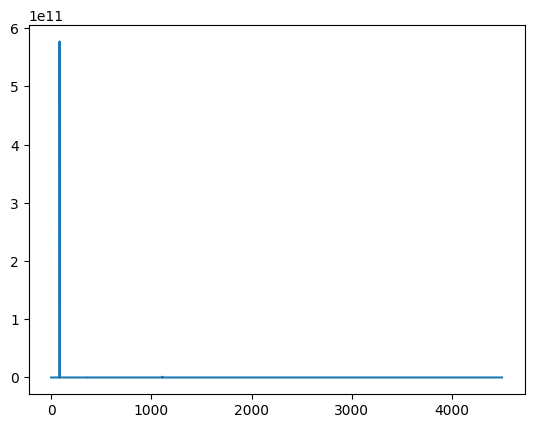

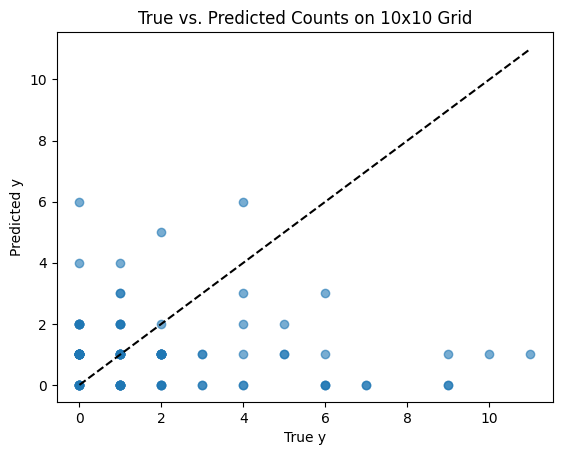

In [8]:
###########################################################
# 6. MAIN: TRAIN, INFER ON "TRUE" DATA, AND PLOT
###########################################################
if __name__ == "__main__":
    # A) Train the model
    trained_model = train_model(n_epochs=4500, batch_size=32, lr=1e-3, obs_fraction=0.7)
    print("\nModel training complete.\n")

    # B) Inference on the "true" dataset with partial observations
    # We'll create an input vector of length=100 with -1 at missing indices and y at observed indices
    masked_true_data = -1.0 * np.ones(n, dtype=np.float32)
    masked_true_data[obs_idx] = y_obs.astype(np.float32)

    # Forward pass
    inp_torch = torch.tensor(masked_true_data).unsqueeze(0)  # shape (1, 100)
    pred_params = trained_model(inp_torch).detach().numpy().flatten()
    ls_hat, var_hat = pred_params
    print("Inferred parameters:")
    print(f"  lengthscale_hat = {ls_hat:.4f}, variance_hat = {var_hat:.4f}")
    print(f"  (True: lengthscale={lengthscale_true}, variance={variance_true})")

    # C) Predict "y" for the entire grid
    rng_pred = random.PRNGKey(888)
    y_pred = predict_counts(pred_params, rng_key=rng_pred)  # shape (100,)

    # D) Plot: true vs. predicted y
    plt.figure()
    plt.scatter(y, y_pred, alpha=0.6)
    plt.xlabel("True y")
    plt.ylabel("Predicted y")
    plt.title("True vs. Predicted Counts on 10x10 Grid")
    plt.plot([0, max(y)], [0, max(y)], 'k--')  # diagonal line for reference
    plt.show()